# ViEWS 3 ensembles: future predictions

ViEWS monthly updates, cm level Fatalities002 version

This notebook produces future predictions for a set of models defined in the list of dictionaries ModelList, produced by the notebook pgm_constituentmodels in this repository.

The notebook draws on the following .py script files in this repository:

Ensembling.py

FetchData.py

It also requires the list of models included in the ensemble, in the following file:
ModelDefinitions.py

In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *
import views_mapper2
from views_mapper2.mapper2 import Mapper2
from views_mapper2 import color
from views_mapper2.label_writer import vid2date
from views_mapper2.dictionary_writer import standard_scale

# Mapper
import geopandas as gpd

import sqlalchemy as sa
#from ingester3.config import source_db_path

# Other packages
import pickle as pkl

#Parallelization
from joblib import Parallel, delayed, cpu_count
from functools import partial


# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
sys.path.append('../SystemUpdates')
import os
from pathlib import Path

# Predicting fatalities scripts
from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated, fetch_df_pg_id_c_id, calibrate_pg_with_c

from FetchData import FetchData, RetrieveFromList, ReturnQsList, index_check
from ViewsEstimators import *

In [4]:
# Common parameters:

dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 508
prod_id = '2022_04_t01'
level = 'pgm'
WriteToOverleaf = False
get_future = True

username = os.getlogin()

depvar = "ln_ged_sb_dep"

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

#steps = [1,2,3,4,5,6,7,8,9,10,11,12,15,18,21,24] # Which steps to train and predict for
#fi_steps = [1,3,6,12,36] # Which steps to present feature importances for
#steps = [1,12,24,36]
fi_steps = [1,3,6,12,36]
#steps = [1,6,36]
#fi_steps = [1,6,36]

# Specifying partitions

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}
test_partitioner_dict = {"train":(121,444),"predict":(445,492)}
future_partitioner_dict = {"train":(121,492),"predict":(493,504)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

Mydropbox = f'/Users/{username}/Dropbox (ViEWS)/ViEWS/'
localgitpath = f'/Users/{username}/views3/'
notebookpath = os.getcwd()

if WriteToOverleaf:
    if EndOfHistory==508:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    if EndOfHistory==509:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    
    print('Overleaf path set to',overleafpath)

print('Dropbox path set to',Mydropbox)


Dropbox path set to /Users/jim/Dropbox (ViEWS)/ViEWS/


# Retrieve models and predictions

In [5]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities002_pgm_baseline_lgbm baseline
1 fatalities002_pgm_conflictlong_lgbm conflictlong
2 fatalities002_pgm_conflictlong_hurdle_lgbm conflictlong
3 fatalities002_pgm_escwa_drought_hurdle_lgbm escwa_drought
4 fatalities002_pgm_escwa_drought_lgbm escwa_drought
5 fatalities002_pgm_natsoc_hurdle_lgbm natsoc
6 fatalities002_pgm_natsoc_lgbm natsoc
7 fatalities002_pgm_broad_hurdle_lgbm broad
8 fatalities002_pgm_broad_lgbm broad
9 fatalities002_pgm_conflict_history_xgb conflicthist
10 fatalities002_pgm_conflict_treelag_hurdle conflicttreelag
11 fatalities002_pgm_conflict_sptime_dist_hurdle conflictsptime_dist


In [6]:
#gitname = 'EnsembleMetaData_pgm_' + dev_id + '.csv'
#EnsembleMetaData = pd.read_csv(gitname)
#ModelList = EnsembleMetaData.to_dict('records')
#i = 0
#for model in ModelList:
#    print(i, model['modelname'])
#    i = i + 1

# Retrieve and calibrate predictions and data

In [7]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, run_id, level, get_future)

0 fatalities002_pgm_baseline_lgbm
pr_46_pgm_fatalities002_pgm_baseline_lgbm_calib.parquet
pr_46_pgm_fatalities002_pgm_baseline_lgbm_test.parquet
pr_46_pgm_fatalities002_pgm_baseline_lgbm_f508.parquet
1 fatalities002_pgm_conflictlong_lgbm
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_calib.parquet
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_test.parquet
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_f508.parquet
2 fatalities002_pgm_conflictlong_hurdle_lgbm
pr_46_pgm_fatalities002_pgm_conflictlong_hurdle_lgbm_calib.parquet
pr_46_pgm_fatalities002_pgm_conflictlong_hurdle_lgbm_test.parquet
pr_46_pgm_fatalities002_pgm_conflictlong_hurdle_lgbm_f508.parquet
3 fatalities002_pgm_escwa_drought_hurdle_lgbm
pr_46_pgm_fatalities002_pgm_escwa_drought_hurdle_lgbm_calib.parquet
pr_46_pgm_fatalities002_pgm_escwa_drought_hurdle_lgbm_test.parquet
pr_46_pgm_fatalities002_pgm_escwa_drought_hurdle_lgbm_f508.parquet
4 fatalities002_pgm_escwa_drought_lgbm
pr_46_pgm_fatalities002_pgm_escwa_drought_lgbm_calib.

In [8]:
ModelList[0].keys()

dict_keys(['modelname', 'algorithm', 'depvar', 'queryset', 'data_train', 'level', 'preprocessing', 'description', 'long_description', 'predstore_calib', 'predstore_test', 'predictions_calib_df', 'predictions_test_df', 'predictions_future_df'])

In [9]:
qslist = ReturnQsList(level)
from FetchData import fetch_pgm_data_from_model_def

Datasets=fetch_pgm_data_from_model_def(qslist)

 .    
A dataset with 8 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 19 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 29 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 24 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 23 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 30 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 8 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 11 columns, with data between t 1 and 852. (13110 units)
 .    escwa_drought: A dataset with 29 columns, with data between t = 1 and 852; 13110 units.
 .    baseline: A dataset with 8 columns, with data between t = 1 and 852; 13110 units.
 .    conflicttreelag: A dataset with 8 columns, with data between t = 1 and 852; 13110 units.
 .    conflictlong: A dataset with 19 columns, with data between t = 1 and 852; 13110 units.


In [10]:
len(Datasets)

8

In [11]:
for model in ModelList:
    print(model['modelname'])
#    print(model['predictions_calib_df'])

fatalities002_pgm_baseline_lgbm
fatalities002_pgm_conflictlong_lgbm
fatalities002_pgm_conflictlong_hurdle_lgbm
fatalities002_pgm_escwa_drought_hurdle_lgbm
fatalities002_pgm_escwa_drought_lgbm
fatalities002_pgm_natsoc_hurdle_lgbm
fatalities002_pgm_natsoc_lgbm
fatalities002_pgm_broad_hurdle_lgbm
fatalities002_pgm_broad_lgbm
fatalities002_pgm_conflict_history_xgb
fatalities002_pgm_conflict_treelag_hurdle
fatalities002_pgm_conflict_sptime_dist_hurdle


In [12]:
calibrate_const_models=False

from views_runs import Storage, StepshiftedModels
from views_partitioning.data_partitioner import DataPartitioner
from viewser import Queryset, Column
from views_runs import operations
from views_runs.run_result import RunResult

RewritePredictions = False # Set this to True to rewrite predictions even if they exist

def RetrainAndPredict(modelname):
    force_retrain = False
    modelstore = storage.Storage()
    # Predictions for true future
    ct = datetime.now()
    print('Future', ct)
    modelstore = storage.Storage()
    model['RunResult_future']  = RunResult.retrain_or_retrieve(
            retrain            = force_retrain,
            store              = modelstore,
            partitioner        = DataPartitioner({"test":future_partitioner_dict}),
            stepshifted_models = StepshiftedModels(model['algorithm'], steps, model['depvar']),
            dataset            = RetrieveFromList(Datasets,model['data_train']),
            queryset_name      = model['queryset'],
            partition_name     = "test",
            timespan_name      = "train",
            storage_name       = model['modelname'] + '_future',
            author_name        = "JED",
    )       
    predictions_future = model['RunResult_future'].run.future_point_predict(EndOfHistory,model['RunResult_future'].data)
    return predictions_future



i = 0
print('Computing predictions, production run ' + prod_id + ', development run ' + run_id)
for model in ModelList:

    # Loop that checks whether (1) this a model trained outside the main system, 
    # (2) retrieves the prediction if it exists in prediction storage,
    # (3) if not checks whether the trained model exists, retrains if not, 
    # Then calibrates the predictions and stores them if they have not been stored before for this run.
    # To do: set the data_preprocessing to the function in the model dictionary
    
#    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    print(i, model['modelname'])

    ct = datetime.now()
    print('Trying to retrieve non-calibrated predictions', ct)
    if RewritePredictions:
        print(model['predstorename_ncal'])
        model['future_df_noncalibrated'] = RetrainAndPredict(model['modelname'])
    else:
        try:
            model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
            print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

        except KeyError:
            print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

    # Calibrating and storing   
    # Storing non-calibrated
        
#    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    print(i, model['modelname'])

    ct = datetime.now()
    print('Trying to retrieve non-calibrated predictions', ct)
    if RewritePredictions:
        model['future_df_noncalibrated'] = RetrainAndPredict(model['modelname'])
    else:
        try:
            model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
            print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

        except KeyError:
            print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

    # Calibrating and storing   
    # Storing non-calibrated
    
#    print('before store',model['future_df_noncalibrated'].index.names)
        
    model['future_df_noncalibrated'].forecasts.set_run(run_id)
    model['future_df_noncalibrated'].forecasts.to_store(name=model['predstorename_ncal'], overwrite=True)   
    
#    print('after store',model['future_df_noncalibrated'].index.names)
    
    if calibrate_const_models:
        print('Calibrating')
        model['future_df_calibrated'] = model['future_df_noncalibrated'].copy()
            
        model['future_df_calibrated']['step_combined']=cal_pg_c(model['future_df_calibrated'],cm_predictions_future,'step_combined',df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)    
        # Storing calibrated
        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   
            
    i = i + 1

print('All done')
        

Computing predictions, production run 2022_04_t01, development run Fatalities002
0 fatalities002_pgm_baseline_lgbm
Trying to retrieve non-calibrated predictions 2022-11-09 11:01:41.369270
pr_46_pgm_fatalities002_pgm_baseline_lgbm_f508.parquet
Predictions for  pgm_fatalities002_pgm_baseline_lgbm_f508 , run Fatalities002 exist, retrieving from prediction storage
0 fatalities002_pgm_baseline_lgbm
Trying to retrieve non-calibrated predictions 2022-11-09 11:01:44.916496
pr_46_pgm_fatalities002_pgm_baseline_lgbm_f508.parquet
Predictions for  pgm_fatalities002_pgm_baseline_lgbm_f508 , run Fatalities002 exist, retrieving from prediction storage


Exception during reset or similar
Traceback (most recent call last):
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 753, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1004, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
psycopg2.DatabaseError: could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out



1 fatalities002_pgm_conflictlong_lgbm
Trying to retrieve non-calibrated predictions 2022-11-09 11:02:18.934191
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_f508.parquet
Predictions for  pgm_fatalities002_pgm_conflictlong_lgbm_f508 , run Fatalities002 exist, retrieving from prediction storage
1 fatalities002_pgm_conflictlong_lgbm
Trying to retrieve non-calibrated predictions 2022-11-09 11:02:22.057394
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_f508.parquet
Predictions for  pgm_fatalities002_pgm_conflictlong_lgbm_f508 , run Fatalities002 exist, retrieving from prediction storage
2 fatalities002_pgm_conflictlong_hurdle_lgbm
Trying to retrieve non-calibrated predictions 2022-11-09 11:02:37.343712
pr_46_pgm_fatalities002_pgm_conflictlong_hurdle_lgbm_f508.parquet
Predictions for  pgm_fatalities002_pgm_conflictlong_hurdle_lgbm_f508 , run Fatalities002 exist, retrieving from prediction storage
2 fatalities002_pgm_conflictlong_hurdle_lgbm
Trying to retrieve non-calibrated predictions 2022-1

In [13]:
EnsembleList = [] # Separate list of dictionaries for ensembles!

Ensemble = {
    'modelname':            'ensemble_cm_calib',
    'algorithm':            [],
    'depvar':               depvar,
    'data_train':           [],
    'Algorithm_text':       '',
    'calibration_gams':     [],
    'future_df_calibrated': [],
}
EnsembleList.append(Ensemble)



In [14]:
cm_ensemble=ViewsMetadata().with_name('cm_genetic_ensemble_f'+str(EndOfHistory)).fetch()

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 753, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1004, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out



In [15]:
calib_run_id=int(cm_ensemble['runs_id'].values[0])

In [16]:
cm_predictions_calib = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_ensemble_genetic_calib')
cm_predictions_test = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_ensemble_genetic_test')
cm_predictions_future = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_genetic_ensemble_f'+str(EndOfHistory))

pr_45_cm_ensemble_genetic_calib.parquet
pr_45_cm_ensemble_genetic_test.parquet
pr_45_cm_genetic_ensemble_f508.parquet


In [17]:
stepcols=['step_pred_' + str(step) for step in steps]

In [18]:
n_models = len(ModelList)

targetcalib=ModelList[0]['predictions_calib_df'][depvar]
targettest=ModelList[0]['predictions_test_df'][depvar]

valscalib=ModelList[0]['predictions_calib_df'][stepcols].values.copy()
valstest=ModelList[0]['predictions_test_df'][stepcols].values.copy()
valsfuture=ModelList[0]['future_df_noncalibrated'].values.copy()

trimmed_calib=ModelList[0]['predictions_calib_df'][stepcols].copy()
index_calib=trimmed_calib.index
columns_calib=trimmed_calib.columns

trimmed_test=ModelList[0]['predictions_test_df'][stepcols].copy()
index_test=trimmed_test.index
columns_test=trimmed_test.columns

trimmed_future=ModelList[0]['future_df_noncalibrated'].copy()
index_future=trimmed_future.index
columns_future=trimmed_future.columns

for model in ModelList[1:]:
    print('adding',model['modelname'])

    valscalib+=model['predictions_calib_df'][stepcols].values.copy()
    valstest+=model['predictions_test_df'][stepcols].values.copy()
    valsfuture+=model['future_df_noncalibrated'].values.copy()

    valscalib/=n_models
    valstest/=n_models
    valsfuture/=n_models

    Ensemble['predictions_calib_df']=pd.DataFrame(data=valscalib, index=index_calib, columns=columns_calib)
    Ensemble['predictions_test_df']=pd.DataFrame(data=valstest, index=index_test, columns=columns_test)
    Ensemble['predictions_future_df']=pd.DataFrame(data=valsfuture, index=index_future, columns=columns_future)
    
df_pg_id_c_id=fetch_df_pg_id_c_id()
    
for col in stepcols:

    thisstep=int(''.join([''+str(f) for f in filter(str.isdigit, col)]))
    thismonth = EndOfHistory + thisstep

    Ensemble['predictions_calib_df'][col]=calibrate_pg_with_c(Ensemble['predictions_calib_df'],cm_predictions_calib,col,df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)

    Ensemble['predictions_test_df'][col]=calibrate_pg_with_c(Ensemble['predictions_test_df'],cm_predictions_test,col,df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)
    
future_calib=calibrate_pg_with_c(Ensemble['predictions_future_df'],cm_predictions_future,'step_combined',df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)    
    
Ensemble['predictions_future_df']['step_combined']=future_calib['step_combined']

adding fatalities002_pgm_conflictlong_lgbm
adding fatalities002_pgm_conflictlong_hurdle_lgbm
adding fatalities002_pgm_escwa_drought_hurdle_lgbm
adding fatalities002_pgm_escwa_drought_lgbm
adding fatalities002_pgm_natsoc_hurdle_lgbm
adding fatalities002_pgm_natsoc_lgbm
adding fatalities002_pgm_broad_hurdle_lgbm
adding fatalities002_pgm_broad_lgbm
adding fatalities002_pgm_conflict_history_xgb
adding fatalities002_pgm_conflict_treelag_hurdle
adding fatalities002_pgm_conflict_sptime_dist_hurdle
 .    

In [19]:
ModelList[1].keys()

dict_keys(['modelname', 'algorithm', 'depvar', 'queryset', 'data_train', 'level', 'preprocessing', 'description', 'long_description', 'predstore_calib', 'predstore_test', 'predictions_calib_df', 'predictions_test_df', 'predictions_future_df', 'predstorename_ncal', 'predstorename_cal', 'future_df_noncalibrated'])

In [20]:
Ensemble['predictions_calib_df'][depvar]=targetcalib
Ensemble['predictions_test_df'][depvar]=targettest

In [21]:
# Save ensemble predictions
predstore_calib = level +  '_' + Ensemble['modelname'] + '_calib'
Ensemble['predictions_calib_df'].forecasts.set_run(run_id)
Ensemble['predictions_calib_df'].forecasts.to_store(name=predstore_calib, overwrite = True)
predstore_test = level +  '_' + Ensemble['modelname'] + '_test'
Ensemble['predictions_test_df'].forecasts.set_run(run_id)
Ensemble['predictions_test_df'].forecasts.to_store(name=predstore_test, overwrite = True)
predstore_future = level +  '_' + Ensemble['modelname'] + '_f'+str(EndOfHistory)
Ensemble['predictions_future_df'].forecasts.set_run(run_id)
Ensemble['predictions_future_df'].forecasts.to_store(name=predstore_future, overwrite = True)

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 753, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1004, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 753, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1004, in _reset
    pool._

# Use ensemble predictions for test partition to create categorical predictions

In [22]:
ensemble_test_df=Ensemble['predictions_test_df'].copy()

In [23]:
Ensemble['predictions_test_df']

step_pred_1  step_pred_2  step_pred_3  step_pred_4  \
month_id priogrid_id                                                       
445      62356           0.000030     0.000085     0.000062     0.000046   
         79599           0.000011     0.000012     0.000030     0.000018   
         79600           0.000011     0.000011     0.000030     0.000019   
         79601           0.000012     0.000012     0.000034     0.000018   
         80317           0.000011     0.000010     0.000021     0.000017   
...                           ...          ...          ...          ...   
492      190496          0.002048     0.003476     0.015028     0.003931   
         190507          0.000319     0.000794     0.001079     0.001704   
         190508          0.000407     0.000817     0.001355     0.001839   
         190510          0.000364     0.000980     0.001599     0.002295   
         190511          0.000382     0.001178     0.001753     0.002041   

                      step_pred_5  step_pred_6  step_pred_7  step_pred_8  \
month_id priogrid_id                                                       
445      62356           0.000040     0.000067     0.000060     0.000072   
         79599           0.000018     0.000044     0.000032     0.000038   
         79600           0.000016     0.000044     0.000032     0.000039   
         79601           0.000016     0.000044     0.000031     0.000037   
         80317           0.000018     0.000034     0.000031     0.000038   
...                           ...          ...          ...          ...   
492      190496          0.003679     0.012142     0.021094     0.054839   
         190507          0.001509     0.001180     0.001462     0.000979   
         190508          0.001838     0.001358     0.001377     0.000906   
         190510          0.001868     0.001230     0.001547     0.000913   
         190511          0.002091     0.001424     0.001842     0.001088   

                      step_pred_9  step_pred_10  ...  step_pred_28  \
month_id priogrid_id                             ...                 
445      62356           0.000023      0.000060  ...      0.000381   
         79599           0.000019      0.000032  ...      0.000133   
         79600           0.000020      0.000032  ...      0.000130   
         79601           0.000017      0.000032  ...      0.000114   
         80317           0.000022      0.000033  ...      0.000144   
...                           ...           ...  ...           ...   
492      190496          0.047354      0.013467  ...      0.029498   
         190507          0.001615      0.001213  ...      0.010124   
         190508          0.001818      0.001327  ...      0.010382   
         190510          0.002050      0.001457  ...      0.011920   
         190511          0.002077      0.001646  ...      0.015361   

                      step_pred_29  step_pred_30  step_pred_31  step_pred_32  \
month_id priogrid_id                                                           
445      62356            0.000162      0.000382      0.000153      0.000140   
         79599            0.000148      0.000209      0.000098      0.000079   
         79600            0.000150      0.000203      0.000098      0.000078   
         79601            0.000105      0.000186      0.000098      0.000070   
         80317            0.000162      0.000220      0.000107      0.000088   
...                            ...           ...           ...           ...   
492      190496           0.028645      0.023755      0.026663      0.029486   
         190507           0.014279      0.017490      0.018148      0.015178   
         190508           0.016120      0.018631      0.016765      0.016060   
         190510           0.016441      0.020141      0.018746      0.017974   
         190511           0.015449      0.019240      0.022460      0.017025   

                      step_pred_33  step_pred_34  step_pred_35  step_pred_36  \
month_id pri

In [24]:
# Generate dichotomous version of dependent variable
ensemble_test_df['ged_gte_25'] = ensemble_test_df['ln_ged_sb_dep'].apply(lambda x: 1 if x >= np.log1p(25) else 0)
# Generate multiclass version for uncertainty estimation
def ged_categorical(x):
    if x < np.log1p(0.5):
        return 0
    elif x < np.log1p(10):
        return 1
    elif x < np.log1p(100):
        return 2
    elif x < np.log1p(1000):
        return 3
    else :
        return 4

ensemble_test_df['ged_multi'] = ensemble_test_df['ln_ged_sb_dep'].apply(ged_categorical)

ensemble_test_df.describe()

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ln_ged_sb_dep,ged_gte_25,ged_multi
count,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,...,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000
mean,0.061167,0.075948,0.082473,0.084267,0.083820,0.099157,0.092823,0.091424,0.109143,0.091078,...,0.136860,0.138508,0.136882,0.126835,0.133745,0.129337,0.130821,0.016279,0.001187,0.010920
std,0.333112,0.385849,0.406256,0.418138,0.397943,0.465317,0.439485,0.449475,0.529336,0.447131,...,0.534171,0.541955,0.524844,0.504415,0.522710,0.519027,0.512169,0.207899,0.034433,0.130805
min,0.000003,0.000009,-0.001903,-0.040460,-0.258168,-0.001175,0.000011,0.000018,0.000014,0.000019,...,0.000063,0.000077,0.000070,0.000090,-0.000292,0.000041,0.000099,0.000000,0.000000,0.000000
25%,0.000156,0.000284,0.000413,0.000366,0.000460,0.000465,0.000546,0.000625,0.000757,0.000659,...,0.001472,0.001519,0.001473,0.001606,0.001613,0.001507,0.001487,0.000000,0.000000,0.000000
50%,0.000747,0.001184,0.001533,0.001637,0.001912,0.002001,0.002189,0.002350,0.002632,0.002634,...,0.006324,0.006799,0.006638,0.006664,0.006968,0.006966,0.007104,0.000000,0.000000,0.000000
75%,0.005054,0.007676,0.008772,0.009616,0.010970,0.011350,0.012623,0.013249,0.015315,0.014367,...,0.033590,0.036144,0.036383,0.034667,0.036592,0.036571,0.038573,0.000000,0.000000,0.000000
max,8.207209,8.010147,8.457104,9.254678,9.160367,9.013112,8.845149,9.117676,10.394057,9.014327,...,9.394703,8.870220,9.103304,9.433605,9.312959,9.523703,9.413598,7.817223,1.000000,4.000000


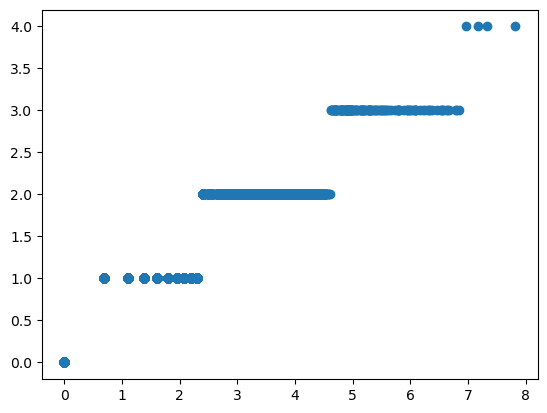

In [25]:
plt.scatter(ensemble_test_df['ln_ged_sb_dep'],ensemble_test_df['ged_multi'])

In [26]:
for step in steps:
    if ensemble_test_df[f'step_pred_{step}'].isnull().sum().sum() != 0:
        print('****WARNING***** - detected',ensemble_test_df[f'step_pred_{step}'].isnull().sum().sum(),'Nan(s) in column step_pred_'+str(step))
        print('Replacing with zeros')
        ensemble_test_df[f'step_pred_{step}']=ensemble_test_df[f'step_pred_{step}'].fillna(0.0)

In [27]:
# Train model to transform predictions from  fatalities to (1) dichotomous and (2) multiclass
from sklearn.linear_model import LogisticRegression
dichotomous_classifiers = []
multi_classifiers = []
for step in steps:
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Dichotomous
    y_dich = np.array(ensemble_test_df['ged_gte_25']).reshape(-1, 1)
    dich_clf = LogisticRegression(random_state=0).fit(X, y_dich)
    dichotomous_classifiers.append(dich_clf)
    p_dich = dich_clf.predict_proba(X)
    ensemble_test_df['dich_step_{step}_logit'] = p_dich[:,1].ravel()
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    p_multi = multi_clf.predict_proba(X)
    for cls in [0,1,2,3,4]:
        ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()

ensemble_test_df.describe()

/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly f

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly f

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly f

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly f

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_34539/2360434821.py:20: PerformanceWarning: DataFrame is highly f

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,multi_0_step_35_logit,multi_1_step_35_logit,multi_2_step_35_logit,multi_3_step_35_logit,multi_4_step_35_logit,multi_0_step_36_logit,multi_1_step_36_logit,multi_2_step_36_logit,multi_3_step_36_logit,multi_4_step_36_logit
count,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,...,629280.000000,629280.000000,629280.000000,629280.000000,6.292800e+05,629280.000000,629280.000000,629280.000000,629280.000000,6.292800e+05
mean,0.061167,0.075948,0.082473,0.084267,0.083820,0.099157,0.092823,0.091424,0.109143,0.091078,...,0.991996,0.005320,0.002458,0.000219,6.369305e-06,0.991997,0.005320,0.002458,0.000219,6.361978e-06
std,0.333112,0.385849,0.406256,0.418138,0.397943,0.465317,0.439485,0.449475,0.529336,0.447131,...,0.034523,0.019015,0.013313,0.002339,1.228699e-04,0.033743,0.018752,0.012878,0.002262,1.080814e-04
min,0.000003,0.000009,-0.001903,-0.040460,-0.258168,-0.001175,0.000011,0.000018,0.000014,0.000019,...,0.014414,0.003244,0.001203,0.000057,5.813771e-07,0.013805,0.003240,0.001227,0.000062,8.738032e-07
25%,0.000156,0.000284,0.000413,0.000366,0.000460,0.000465,0.000546,0.000625,0.000757,0.000659,...,0.995331,0.003248,0.001205,0.000057,5.826412e-07,0.995292,0.003244,0.001229,0.000062,8.755380e-07
50%,0.000747,0.001184,0.001533,0.001637,0.001912,0.002001,0.002189,0.002350,0.002632,0.002634,...,0.995465,0.003265,0.001212,0.000057,5.873703e-07,0.995438,0.003262,0.001236,0.000063,8.825959e-07
75%,0.005054,0.007676,0.008772,0.009616,0.010970,0.011350,0.012623,0.013249,0.015315,0.014367,...,0.995489,0.003358,0.001251,0.000060,6.136931e-07,0.995464,0.003363,0.001279,0.000065,9.231976e-07
max,8.207209,8.010147,8.457104,9.254678,9.160367,9.013112,8.845149,9.117676,10.394057,9.014327,...,0.995496,0.443783,0.425560,0.138729,1.171569e-02,0.995470,0.455719,0.421536,0.129768,8.819344e-03


In [28]:
EnsembleList[0]['future_df_dichotomous'] = EnsembleList[0]['predictions_future_df'].copy() # Copy from baseline

for step in steps:
    month = EndOfHistory + step
#    weightcol = 'step_pred_' + str(step)
#    weights = np.array(pd.DataFrame(i_weights_df[weightcol]))
#    EnsembleList[0]['future_df_calibrated'].loc[month] = ConstituentModels_df_w.loc[month].dot(weights).values
    x_d = np.array(EnsembleList[0]['predictions_future_df'].loc[month]).reshape(-1,1)
    pred_step = dichotomous_classifiers[step-1].predict_proba(x_d)
    EnsembleList[0]['future_df_dichotomous']['step_combined'].loc[month] = pred_step[:,1]

In [29]:
predstore_future_dich = level +  '_' + EnsembleList[0]['modelname'] + '_dich_f' + str(EndOfHistory)
EnsembleList[0]['future_df_dichotomous'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_dichotomous'].forecasts.to_store(name=predstore_future_dich, overwrite = True) 

# Mapping future predictions

In [38]:
# get pgm geometries
gdf_base = gpd.read_parquet('../Tools/geometry/pgm_geometry.parquet')

In [39]:
# get cm geometries
gdf_c = gpd.read_parquet('../Tools/geometry/cm_geometry.parquet')
gdf_c = gdf_c.to_crs(4326)

In [40]:
df_with_wanted_index=Datasets[0]['df']

index_check(EnsembleList[0],df_with_wanted_index)

In [41]:
# Future prediction maps, predictions, rolling
#path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/'
stepstoplot=[3,5,6,8,12,18,24,36]
#titles = [vid2date(i) for i in stepstoplot + EndOfHistory]


df = Ensemble['predictions_future_df'].copy()
gdf2 = gdf_base.copy()
df = df.join(gdf2.set_index("priogrid_gid"))
gdf3 = gpd.GeoDataFrame(df, geometry="geom")

In [47]:
path = Mydropbox + 'Projects/PredictingFatalities/Predictions/pgm/preds/'

In [48]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
#        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=0.7,facecolor='None')
        
#        m.cbar.set_ticks(standard_scale)
#        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

In [ ]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[29.446846321370213, 50.987309710685814, 1.1561557161401845, 18.29970129951559], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=m.fig
        fontdict={'fontsize':20}
        figure.text(0.4,0.45,'ETHIOPIA',fontdict=fontdict,color='black')
        figure.text(0.2,0.7,'SUDAN',fontdict=fontdict,color='black')
        figure.text(0.15,0.35,'S. SUDAN',fontdict=fontdict,color='black')
        figure.text(0.65,0.5,'SOMALIA',fontdict=fontdict,color='black')
        figure.text(0.35,0.25,'KENYA',fontdict=fontdict,color='black')
        
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_Ethiopia_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

In [ ]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-2.3019466946294584, 20.374695512438592, 1.103974761908613, 16.794164972712068], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=m.fig
        fontdict={'fontsize':20}
        figure.text(0.4,0.45,'NIGERIA',fontdict=fontdict,color='black')
        figure.text(0.4,0.7,'NIGER',fontdict=fontdict,color='black')
        figure.text(0.5,0.35,'CAMEROON',fontdict=fontdict,color='black')
        figure.text(0.7,0.60,'CHAD',fontdict=fontdict,color='black')
        figure.text(0.7,0.4,'C.A.R.',fontdict=fontdict,color='black')
        figure.text(0.15,0.60,'B. FASO',fontdict=fontdict,color='black')
        
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_Nigeria_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

# Changes to 3- and 6-month forecasts, and since last actual observation


In [ ]:
# Reading in data for mapping
# Predictions now and then
predstore_then = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory-3)

df_now = EnsembleList[0]['predictions_future_df'].copy()

df_then=ViewsMetadata().with_name('ensemble_cm_calib_f'+str(EndOfHistory-3)).fetch()

try:
    df_then = pd.DataFrame.forecasts.read_store(run=run_id, name=predstore_then)
except:
    print('Trouble reading forecasts issued three months ago')
    
# Actuals

df_lastobserved = Datasets[0]['df']

In [ ]:
# Compute log of mean non-logged fatalities, past six months
df_observed = df_lastobserved.loc[EndOfHistory]
df_observed['ged_sb_0'] = np.expm1(df_observed['ln_ged_sb'])
df_observed['ged_sum'] = df_observed['ged_sb_0']
for t in [1,2,3,4,5]:
    colname = 'ged_sb_' + str(t)
    df_observed[colname] = np.expm1(df_lastobserved.loc[EndOfHistory-t]['ln_ged_sb'])
    df_observed['ged_sum'] = df_observed['ged_sum'] + df_observed[colname]
df_observed['ln_ged_sum'] = np.log1p(df_observed['ged_sum']/6)
#df_observed.tail(20)

In [ ]:
StepsForward = [
{
    'Step': 3,
    'df_now': df_now.loc[EndOfHistory + 3],
    'df_then': df_then.loc[EndOfHistory - 3 + 3]
},
{
    'Step': 6,
    'df_now': df_now.loc[EndOfHistory + 6],
    'df_then': df_then.loc[EndOfHistory - 3 + 6]
},
]
engine = sa.create_engine(source_db_path)
#predictors_df = data_vdem_short.loc[EndOfHistory]
#predictors_df_3m = data_vdem_short.loc[EndOfHistory-3]

for s in StepsForward:
    s['df_now'].rename(columns={'step_combined':'Now'}, inplace=True)
    s['df_then'].rename(columns={'step_combined':'Then'}, inplace=True)
    s['df'] = pd.concat([s['df_now'],s['df_then'],df_observed['ln_ged_sum']],axis=1)
    s['df']['Change_in_prediction'] = s['df']['Now']-s['df']['Then']
    s['df']['Change_since_last_observed'] = s['df']['Now']-s['df']['ln_ged_sum']
    
#    # Surrogate model change
#    for sm in SurrogateModelList:
#        if sm['Step'] == s['Step']:
#            s['sdf'] = predictors_df[sm['Columns']]
#            s['sdf'][sm['Predcolname']] = sm['GAM'].predict(predictors_df[sm['Columns']])
#            s['sdf_3m'] = predictors_df_3m[sm['Columns']]
#            s['sdf_3m'][sm['Predcolname']] = sm['GAM'].predict(predictors_df_3m[sm['Columns']])
#            print(sm['Step'],sm['Predcolname'])
#            dfcolname = sm['Predcolname'][:-2] + '_ch3m'
#            s['df'][dfcolname] = s['sdf'][sm['Predcolname']] - s['sdf_3m'][sm['Predcolname']]
    
    s['gdf'] = gdf_base
    s['gdf'] = s['gdf'].to_crs(4326)

    s['gdf_t'] = s['df'].join(s['gdf'].set_index("priogrid_gid"))
    s['gdf'] = gpd.GeoDataFrame(s['gdf_t'], geometry="geom")
    
    
StepsForward[0]['gdf'].describe()

In [ ]:
tickvalues = np.array([-80,-50,-20,0,20,50,100,200,500])
print(tickvalues)
ticklabels=[str(tv) for tv in tickvalues]
tickvalues = np.log((100+tickvalues)/100)
print(tickvalues)

In [ ]:
path= Mydropbox + f'DataReleases/MonthlyUpdates/{run_id}_{prod_id}/Continuous/Ensemble/ChangeMaps/'

In [ ]:
delta = 3

tickvalues=np.array([-300,-30,-3,3,30,300])
ticklabels=[str(tv) for tv in tickvalues]

tickvalues=np.sign(tickvalues)*np.log1p(np.abs(tickvalues)+1)
#print(tickvalues)
tickvalues = np.array([-83,-80,-50,-20,0,20,50,100,200,500])
ticklabels=[str(tv) for tv in tickvalues]
ticklabels[0] = ""
tickvalues = np.log((100+tickvalues)/100)


t0s=range(508,509) # From start of month A, to start of (but not including) month B
bbox="africa_middle_east"
cmap='bwr'#'rainbow'
for s in StepsForward:
    for column in ['Change_in_prediction','Change_since_last_observed']:
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title=f"{column}, s= {s['Step']}",
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=s['gdf'],
        map_scale=surrogate_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column=column, 
        inform_colorbar=True
        )
        m.cbar.set_ticks(surrogate_scale)
        m.cbar.set_ticklabels(surrogate_scale_labels)

        m.save(path+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
#        if WriteToOverleaf:
#            plot.save(overleafpath+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
        